In [1]:
from neural import fit_surrogate
import numpy as np
import pycalphad
from pycalphad import Database, calculate, variables as v

starting_temp = 300
max_temp = 600
step = 5
fine_temps = np.arange(starting_temp, max_temp, step)
print(fine_temps.shape)
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'ZN', 'VA']

pts = np.array([[[0.3, 0.3, 0.4]]])

res = calculate(dbf, comps, 'LIQUID', T=fine_temps, P=1e5, N=1, pdens=10, output='GM', points=pts)
data = res.GM
data = data[0,0,:,:]

(60,)


In [ ]:
  res = calculate(dbf, comps, phase_name, T=temp_range, P=1e5, N=1, model=mod, pdens=10)
    print('test6')
    # Get resulting data into tabular form
    filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                    .unstack('internal_dof')\
                    .droplevel(level='component')\
                    .reset_index().drop(columns=['N', 'P', 'points'])
    # Not sure how to fix the duplicate energy column yet
    site_fractions = res.Y.values
    filtered = filtered.values[:, :1+site_fractions.shape[-1]+1]
    x_orig = filtered[:, :-1]
    y_orig = filtered[:, -1]
    # Create Keras Model
    sublattice_dof = [len(t) for t in mod.constituents]
    temp_scale = x_orig[:, 0].max()
    energy_scale = y_orig.std()
    ml_model = CalphadPhaseModel(sublattice_dof, mod.site_ratios, name=phase_name,
                                 temp_scale=temp_scale, energy_scale=energy_scale)
    ml_model.compile(optimizer='adam', loss='mae')
    history = ml_model.fit(x=x_orig, y=y_orig, epochs=200, verbose=0, callbacks=keras.callbacks.TerminateOnNaN(), **kwargs)

In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import math


starting_temp = 300
max_temp = 600
step = 5
fine_temps = np.arange(starting_temp, max_temp, step)

x_train=fine_temps
T = x_train
y_train = calculate(dbf, comps, 'LIQUID', T=T, P=1e5, N=1, pdens=10, output='GM', points=pts)
print(y_train.GM.shape)
y_train = y_train.GM[0,0,:]
print('y_train shape', y_train.shape)
GHSERMG = -8367.34+143.675547*T-26.1849782*T*np.log(T)
y_train += GHSERMG
GHSERMG = -8367.34+143.675547*T-26.1849782*T*np.log(T)
GHSERSI = -8162.609+137.236859*T-22.8317533*T*np.log(T)
GHSERZN = -7285.787+118.470069*T-23.701314*T*np.log(T)
y_train -= (y_train[:, 1] * GHSERMG + y_train[:, 2] * GHSERSI + y_train[:, 3] * GHSERZN)
x_train=x_train.reshape(len(x_train),1)

starting_temp = 500
max_temp_test = 800
step = 1
fine_temps_test = np.arange(starting_temp, max_temp_test, step)
print(fine_temps.shape)


x_test=fine_temps_test
T = x_test
y_test=8202.243-8.83693*T-8.0176E-20*T**7
GHSERMG = -8367.34+143.675547*T-26.1849782*T*np.log(T)
GHSERSI = -8162.609+137.236859*T-22.8317533*T*np.log(T)
GHSERZN = -7285.787+118.470069*T-23.701314*T*np.log(T)
y_test -= (x_test[:, 1] * GHSERMG + x_test[:, 2] * GHSERSI + x_test[:, 3] * GHSERZN)
x_test=x_test.reshape(len(x_test),1)

print('Train')
model = Sequential()
model.add(Dense(units=200, input_dim=1))
model.add(Activation('relu'))
model.add(Dense(units=45))
model.add(Activation('relu'))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error',
              optimizer='sgd')

model.fit(x_train, y_train, epochs=40, batch_size=50, verbose=0)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=10)

classes = model.predict(x_test, batch_size=1)

test=x_test.reshape(-1)
plt.plot(test,y_test,c='r')
plt.plot(test,classes,c='b')
plt.xlabel('Temperatures')
plt.ylabel('GM values')
plt.show()

plt.plot(test,y_test,c='r')
plt.plot(test,loss_and_metrics,c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

(1, 1, 60, 1)
y_train shape (60, 1)


ValueError: non-broadcastable output operand with shape (60,1) doesn't match the broadcast shape (60,60)

In [66]:
loss_and_metrics

nan

In [43]:
import tensorflow as tf

tt, xx = np.broadcast_arrays(fine_temps[:, np.newaxis], np.squeeze(pts)[np.newaxis])
inputs = np.concatenate((fine_temps[np.newaxis].T, xx), axis=1)
# gradients = tf.gradients(model.predict(inputs), inputs)
print(inputs[:,0].shape)
gm_ml = model.predict(inputs[:,0])
sm_ml = -np.gradient(gm_ml[:,0], fine_temps)
product = fine_temps * sm_ml.T
hm_ml = gm_ml[:,0] + fine_temps * sm_ml.T
hm_ml.shape

(60,)
2/2 [==============================] - 0s 3ms/step


(60,)

In [44]:
res = calculate(dbf, comps, 'LIQUID', T=fine_temps, P=1e5, N=1, pdens=10, output='HM', points=pts)
resHM = res.HM
resHM = resHM[0,0,:,0]
resHM.shape

(60,)

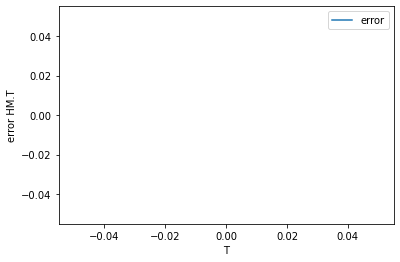

In [46]:
error = resHM - hm_ml
error.shape
plt.plot(fine_temps, error, label='error')
plt.ylabel('error HM.T')
plt.xlabel('T')
plt.legend()
plt.savefig('liquid-Deep-error-above900.png')

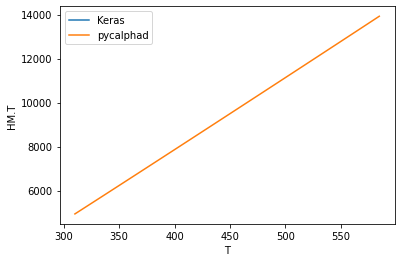

In [37]:
plt.plot(fine_temps[2:-2], hm_ml[2:-2], label='Keras')
plt.plot(fine_temps[2:-2], resHM[2:-2], label='pycalphad')
plt.ylabel('HM.T')
plt.xlabel('T')
plt.legend()
plt.savefig('liquid-NN-comparison.png')